In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 138 (delta 4), reused 10 (delta 4), pack-reused 127
Receiving objects: 100% (138/138), 599.47 KiB | 3.82 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
%cd /content/stylegan2

/content/stylegan2


In [ ]:
!pip install googledrivedownloader

In [ ]:
import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
#'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
Gs.vars["dlatent_avg"].value().eval()

array([ 4.69399601e-01,  5.19922614e-01,  7.61840940e-01, -4.57984209e-02,
        1.06809235e+00,  1.39685225e+00,  1.52100205e-01,  6.83534145e-02,
        1.80047542e-01,  9.98223424e-02,  1.26816773e+00,  1.71921492e-01,
        2.20608759e+00,  1.22328341e+00,  1.08799422e+00,  1.80976018e-02,
       -3.34363043e-01, -5.40801063e-02,  8.36406529e-01,  1.22908545e+00,
       -4.34626937e-02,  1.14429832e-01, -1.59501582e-01,  9.67764378e-01,
        4.06472445e-01, -6.25084192e-02, -2.49396086e-01,  3.99684794e-02,
       -2.61142880e-01,  7.24299788e-01, -8.80684704e-02, -2.28114389e-02,
        3.49023879e-01,  2.19486535e-01, -1.87090114e-01, -9.51050520e-02,
       -1.00772254e-01,  1.19091058e+00, -7.59095922e-02,  3.96770507e-01,
       -1.68704450e-01,  3.90192002e-01, -4.01386619e-01, -5.28093427e-02,
       -1.11889228e-01,  4.28982079e-01,  8.78612757e-01,  3.99716914e-01,
        6.64873898e-01,  3.26022178e-01,  6.81805730e-01,  1.31156373e+00,
        1.02016938e+00,  

In [ ]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
!pip install tqdm

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

# note that intermediate vector (truncated) -> ⱳ_new = ⱳ_avg + 𝞧(ⱳ - ⱳ_avg)

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=30)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

[1244177 9719274 5978481 8559008 7606287 6175296 3419179 3464086 6584077
 3323279 4258732 5287948 8468595 8870993 7914011  557172 8326660 4886410
  168296  763277 3764981 3119891 2588806 4857222  242286 8348729 8504904
 2333683 9771704 3224965]


30it [00:04,  7.25it/s]


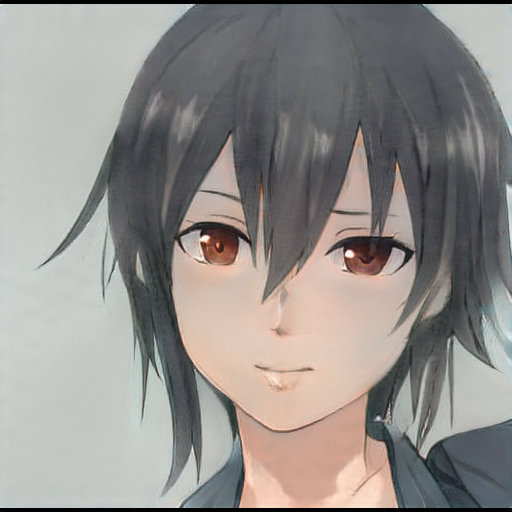

In [ ]:
imgs[1]

In [ ]:
len(imgs)

30

In [ ]:
# from google.colab import files
# x = 1
# for i in imgs:
#   i.save(str(x) + ".png")
#   files.download(str(x) + ".png")
#   x += 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

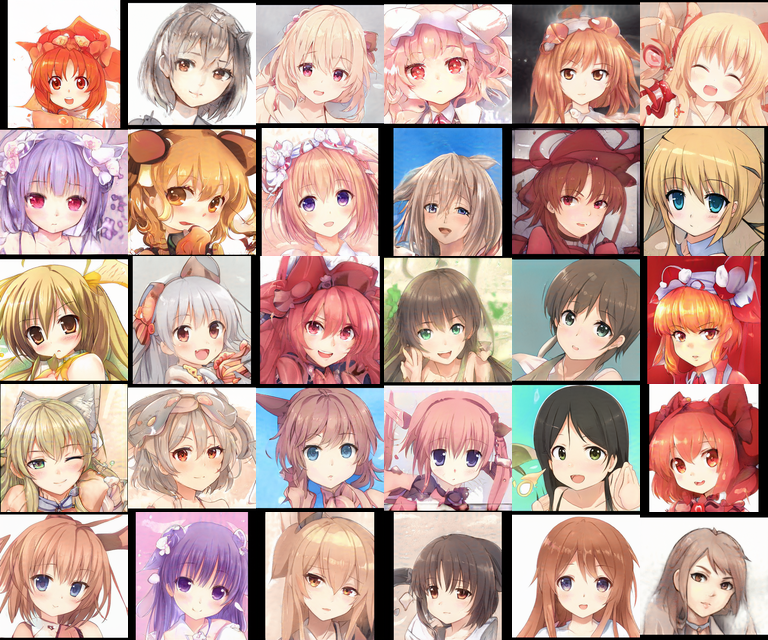

In [ ]:
createImageGrid(imgs, rows=5)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)

7it [00:02,  2.68it/s]


7it [00:00,  7.57it/s]


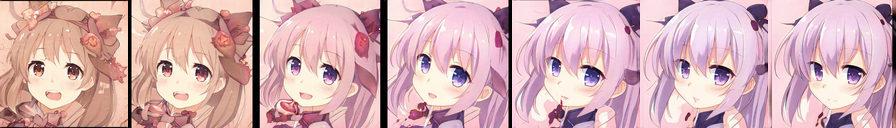

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)